In [1]:
import math
import random

import heapq
from dataclasses import dataclass
from typing import Union, Tuple
from collections import defaultdict

import numpy as np

%matplotlib notebook
import matplotlib 
import matplotlib.pyplot as plt

import environment_2d

In [2]:
np.random.seed(4)

In [3]:
@dataclass
class UnionFindNode:
    """ Class for keeping Union Find Node data"""
    value: int # Value of node
    parent: int # Parent node value
    rank: int # Higher bound on height

class UnionFind:
    def __init__(self):
        
        self.nodes = {}
        
    def make_set(self, x: int) -> None:
        if x not in self.nodes:
            self.nodes[x] = UnionFindNode(x, x, 0)
        
    def find(self, x: int) -> Union[int, None]:
        """ Return root of set x belongs to. None if x does not exist in any set """
        # Check if x exist in any set
        if x not in self.nodes:
            return None
        
        # Search for root and path compression
        cur_node = self.nodes[x]
        while cur_node.parent != cur_node.value:
            parent_node = self.nodes[cur_node.parent]
            cur_node, parent_node = parent_node, self.nodes[parent_node.parent]
            
        return cur_node.value
        
    def union(self, x: int, y: int):
        a = self.nodes[self.find(x)]
        b = self.nodes[self.find(y)]
        
        if a != b:
            # Union if x and y is not part of same set
            if a.rank < b.rank:
                a,b = b,a # Swap to make a at least as large as b

            b.parent = a.value # Re-parent
            if a.rank == b.rank:
                a.rank += 1 # Re calculate rank
        

In [4]:
def dijkstra(adj_list: list, dist_list: list, start_ind: int, end_ind: int) -> Tuple[list, list]:
    prio_q = []
    visited = set()
    parent = {}
    parent[start_ind] = None
    ref_dict = {}
    ref_dict[start_ind] = [0, start_ind]

    heapq.heappush(prio_q, ref_dict[start_ind])

    while len(prio_q) != 0:
        min_dist, min_node_ind = heapq.heappop(prio_q)
        visited.add(min_node_ind)

        if min_node_ind == end_ind:
            # End node found
            break

        neighbor_ind = adj_list[min_node_ind]
        neighbor_dist = dist_list[min_node_ind]

        queue_modified = False

        for n_ind, n_dist in zip(neighbor_ind, neighbor_dist):

            n_new_d = min_dist + n_dist
            if n_ind not in visited:
                if n_ind in ref_dict:
                    # Already in priority queue 
                    if ref_dict[n_ind][0] > n_new_d:
                        # New weight less -> reduce weight and change parent
                        ref_dict[n_ind][0] = n_new_d
                        parent[n_ind] = min_node_ind
                        queue_modified = True
                else:
                    # Not in priotity queue -> add to queue
                    ref_dict[n_ind] = [n_new_d, n_ind]
                    parent[n_ind] = min_node_ind
                    prio_q.append(ref_dict[n_ind])
                    queue_modified = True

        if queue_modified:
            heapq.heapify(prio_q) # Used append to add then call heapify so no repeated shifts

    if end_ind not in parent:
        return [], []

    # Traceback
    path_ind = []
    path_dist = []
    cur_ind = end_ind
    while(cur_ind is not None):
        path_ind.append(cur_ind)
        path_dist.append(ref_dict[cur_ind][0])
        cur_ind = parent[cur_ind]

    return path_ind[::-1], path_dist[::-1]

In [5]:
class PRM:
    """ Probabilistic Roadmap Class """
    def __init__(self, env, radius):
        self.env = env
        
        self.bounds = np.array([self.env.size_x, self.env.size_y], dtype=float)
        self.r = radius
        self.r2 = radius * radius
    
        self.reset()
    
    def reset(self):
        """ Reset working storage """
        self.nodes = []
        self.adj_list = []
        self.dist_list = []
        self.eq_set = UnionFind()
        
        
    def add_node(self, max_random_attempts : int = 100) -> bool:
        """ Add node to the roadmap
        
        Parameters
        ----------
        max_random_attemps
        
        Returns
        ----------
        bool: if node was added
        """
        
        # Sample random point in configuration space
        point_found = False
        for i in range(max_random_attempts):
            rand_point = np.multiply(np.random.rand(2), self.bounds)
            if not self.env.check_collision_np(rand_point):
                point_found = True
                break
        
        if not point_found:
            return False 
        
        # Starting Condition
        if len(self.nodes) == 0:
            self.nodes.append(rand_point)
            self.adj_list.append([])
            self.dist_list.append([])
            self.eq_set.make_set(0)
            return True
        
        # Find neighbouring points within radius to connect to
        nodes_np = np.array(self.nodes)
        d = nodes_np - rand_point
        dist2 = np.sum(np.power(d,2), 1)
        dist = np.sqrt(dist2)
        in_rad_mask = dist2 < self.r2
        
        inds = np.where(in_rad_mask)[0]
        
        new_n = len(self.nodes)
        connect = []
        connect_dist = []
        self.eq_set.make_set(new_n)
        
        # Check traversibility to the neighbour node then connect graph
        for i in range(len(inds)):
            ind = inds[i]
            if self.env.check_segment_outside_np(rand_point.reshape(2,), nodes_np[ind].reshape(2,)):
                # Add cur side
                connect.append(ind)
                connect_dist.append(dist[ind])
                
                # Add neighbour side
                self.adj_list[ind].append(new_n)
                self.dist_list[ind].append(dist[ind])
                
                self.eq_set.union(new_n, ind)
                
        self.nodes.append(rand_point)
        self.adj_list.append(connect)
        self.dist_list.append(connect_dist)
        
        return True
    
    def query_path(self, start: np.array, end: np.array) -> Tuple[list, list]:
        
        # Get visibility of start and end point to the graph
        start_visible = []
        end_visible = []
        
        for i, node in enumerate(self.nodes):
            if self.env.check_segment_outside_np(start, node):
                start_visible.append((i, np.linalg.norm(start - node)))
                
            if self.env.check_segment_outside_np(end, node):
                end_visible.append((i, np.linalg.norm(end - node)))
                
        start_dict = defaultdict(list)
        end_dict = defaultdict(list)
        
        for ind, dist in start_visible:
            root = self.eq_set.find(ind)
            start_dict[root].append((ind, dist))
            
        for ind, dist in end_visible:
            root = self.eq_set.find(ind)
            end_dict[root].append((ind, dist))

        common_sets = start_dict.keys() & end_dict.keys()
 
        if len(common_sets) == 0:
            return [], []
        
        path_ind = []
        path_dist = []
        
        adj_list = self.adj_list
        dist_list = self.dist_list
        
        start_ind = len(adj_list)
        end_ind = start_ind + 1
        
        for c in common_sets:
            # Search each set seperately for efficiency
            # If not in the same set then dijkstra might
            # need to flood the whole subgraph before returning
            
            # Setup edges to start point
            inds = []
            dists = []
            for ind, dist in start_dict[c]:
                adj_list[ind].append(start_ind)
                dist_list[ind].append(dist)
                
                inds.append(ind)
                dists.append(dist)
            
            adj_list.append(inds)
            dist_list.append(dists)
            
            # Setup edges to end point
            inds = []
            dists = []
            for ind, dist in end_dict[c]:
                adj_list[ind].append(end_ind)
                dist_list[ind].append(dist)
                
                inds.append(ind)
                dists.append(dist)
            
            adj_list.append(inds)
            dist_list.append(dists)
            
            # Search
            search_path, search_path_dist = dijkstra(self.adj_list, self.dist_list, start_ind, end_ind)
            
            if len(path_ind) == 0:
                path_ind = search_path
                path_dist = search_path_dist
            else:
                if len(search_path) != 0:
                    if path_dist[-1] > search_path_dist[-1]:
                        path_ind = search_path
                        path_dist = search_path_dist
                    
            # Clear edges to end point
            for ind, dist in end_dict[c]:
                adj_list[ind].pop()
                dist_list[ind].pop()
            adj_list.pop()
            dist_list.pop()
            
            # Clear edges to start point
            for ind, dist in start_dict[c]:
                adj_list[ind].pop()
                dist_list[ind].pop()
            adj_list.pop()
            dist_list.pop()
            
        path = []
        if len(path_ind) > 2:
            path.append(start)
            for ind in path_ind[1:-1]:
                path.append(self.nodes[ind])
            path.append(end)
            
        return path, path_dist
    
    def search(self, start: np.array, end: np.array, max_iterations: int, query_period: int, max_random_attemps:int = 100) -> Tuple[list, list]:
        
        # See if path already exist
        path, path_dist = self.query_path(start, end)
        if len(path) != 0:
            return path, path_dist
        
        period_count = 0
        
        for i in range(max_iterations):
            added = self.add_node()
            
            period_count += 1
            
            if period_count >= query_period:
                path, path_dist = self.query_path(start, end)
                if len(path) != 0:
                    return path, path_dist
                
                period_count = 0
                
        return [], []
                
    def dijkstra_nodes(self, start_ind: int, end_ind: int) -> Tuple[list, list]:
        """ Path search from start_ind node to end_ind node using dijkstra's algorithm """
        # Check if both are points are in the same subgraph
        if self.eq_set.find(start_ind) != self.eq_set.find(end_ind):
            # No path found
            return [], []
        
        return dijkstra(self.adj_list, self.dist_list, start_ind, end_ind)
    
    def plot(self, c='b'):
        nodes_np = np.array(self.nodes)
        
        plt.scatter(nodes_np[:,0], nodes_np[:,1], c=c)
        
        # No duplicate filter because only for debug visualization
        for src_ind, li in enumerate(self.adj_list):
            src_node = self.nodes[src_ind]
            for dst_ind in li:
                dst_node = self.nodes[dst_ind]
                plt.plot([src_node[0], dst_node[0]], [src_node[1], dst_node[1]], c)
                
        plt.show()

In [6]:
def plot_path(path):
    path_np = np.array(path)
    
    plt.plot(path_np[:,0], path_np[:,1], 'g*-')
    plt.scatter([path_np[0,0]], [path_np[0,1]], c='y')
    plt.scatter([path_np[-1,0]], [path_np[-1,1]], c='m')

In [7]:
def path_shortcut(env, orig_path: list, orig_path_dist: list, iterations: int, max_random_iteration: int = 100):
    
    path = orig_path
    dirs = [ path[i+1] - path[i] for i in range(len(path)-1) ]
    dist = orig_path_dist
    
    for i in range(iterations):
        
        # Generate random a point pair, not on the same segment
        for i in range(max_random_iteration):
            t_1 = random.random() * dist[-1]
            t_2 = random.random() * dist[-1]

            ind_1, ind_2 = np.searchsorted(dist, [t_1, t_2])
            if ind_1 != ind_2:
                break
        else:
            continue

        # Order points to make t1 < t2
        if ind_1 > ind_2 :
            ind_1, ind_2 = ind_2, ind_1
            t_1, t_2 = t_2, t_1
            
        # Generate points from proportion
        dist_seg_1 = dist[ind_1] - dist[ind_1-1]
        dist_seg_2 = dist[ind_2] - dist[ind_2-1]
        
        dist_pro_1 = t_1 - dist[ind_1-1]
        dist_pro_2 = t_2 - dist[ind_2-1]
        
        p_1 = (dist_pro_1 / dist_seg_1)
        p_2 = (dist_pro_2 / dist_seg_2)
        
        v_1 = dirs[ind_1-1] * p_1
        v_2 = dirs[ind_2-1] * p_2
        
        point_1 = path[ind_1-1] + v_1
        point_2 = path[ind_2-1] + v_2
        
        if env.check_segment_outside_np(point_1, point_2):
            # Update path, direction and distance
            seg = point_2 - point_1
            
            new_path = path[:ind_1]
            new_path.append(point_1)
            new_path.append(point_2)
            new_path.extend(path[ind_2:])
            
            dist_a = (dist[ind_1] - dist[ind_1-1]) * p_1
            dist_c = (dist[ind_2] - dist[ind_2-1]) * (1 - p_2)
            
            dist_d = np.linalg.norm(seg)
            dist_b = (dist[ind_2] - dist[ind_1-1]) - (dist_a + dist_c)
            
            dist_change = dist_d - dist_b
            
            new_dist = dist[:ind_1]
            new_dist.append(new_dist[-1] + dist_a)
            new_dist.append(new_dist[-1] + dist_d)
            new_dist.append(new_dist[-1] + dist_c)
            for d in dist[ind_2+1:]:
                new_dist.append(d + dist_change)
            
            new_dirs = dirs[:ind_1-1]
            new_dirs.append(v_1)
            new_dirs.append(seg)
            new_dirs.append(dirs[ind_2-1] - v_2)
            new_dirs.extend(dirs[ind_2:])
            
            path = new_path
            dirs = new_dirs
            dist = new_dist
                            
    return path, dist

### Solving Exercise

In [8]:
# Generating Environment
env = environment_2d.EnvironmentFast(10, 6, 5)

<IPython.core.display.Javascript object>


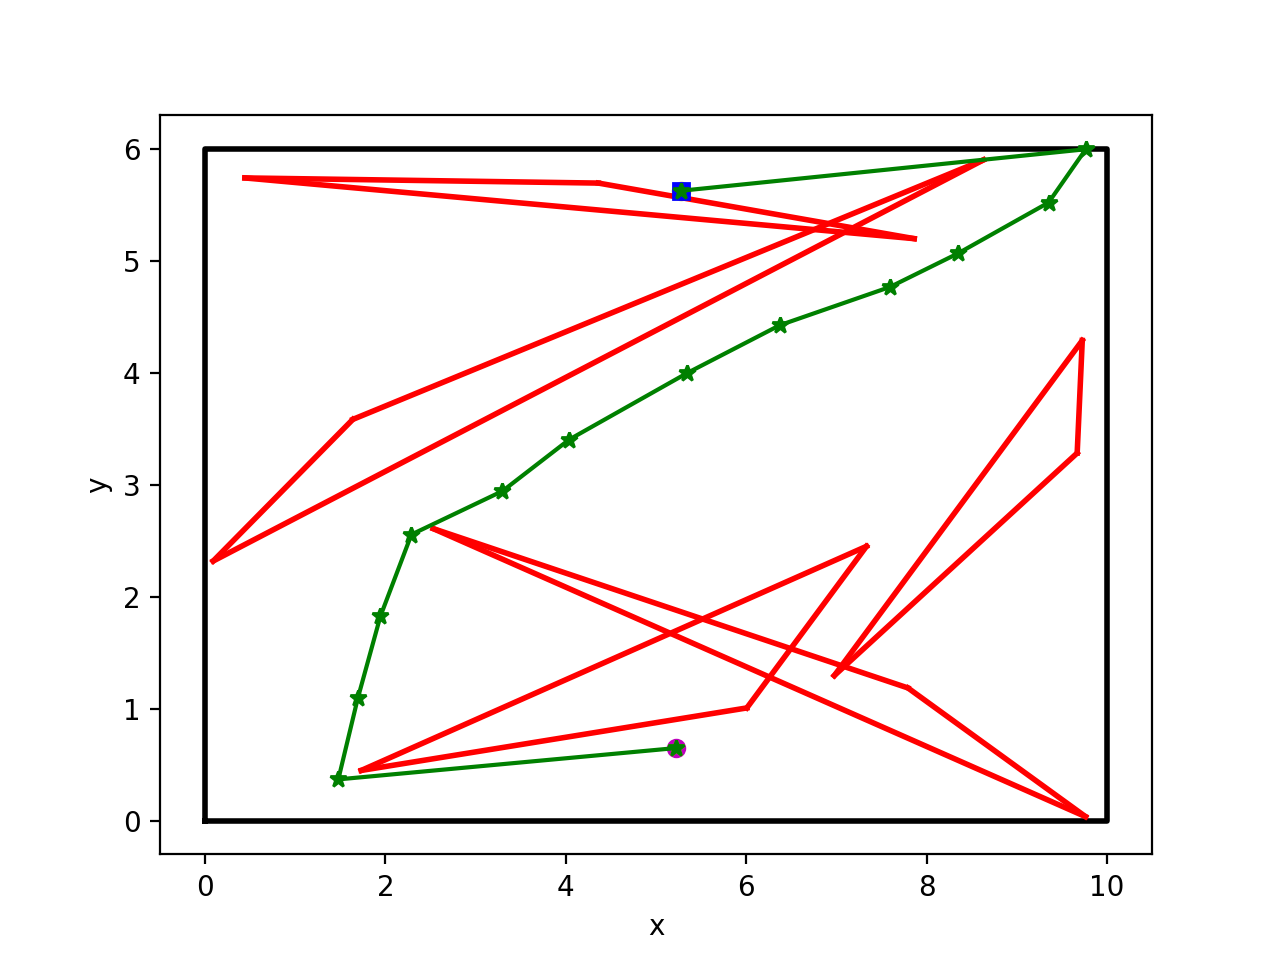

In [9]:
# Plot Environment
fig1 = env.plot()

In [10]:
# Generate random start - goal points
q = env.random_query()
start_point = np.array([q[0], q[1]])
end_point = np.array([q[2], q[3]])

In [11]:
# Plot start - goal points
env.plot_point(start_point, "bs")
env.plot_point(end_point, "y*")

In [12]:
CONNECT_RADIUS = 1.5

SEARCH_ITERATION = 300
PATH_QUERY_PERIOD = 15

SHORTCUT_ITERATION = 1000

In [13]:
# Create Probabilistic Roadmap
prm = PRM(env, CONNECT_RADIUS)

In [14]:
# Path search from start to goal
path, path_dist = prm.search(start_point, end_point, SEARCH_ITERATION, PATH_QUERY_PERIOD)

In [15]:
# Plot unprocessed path
plot_path(path)

In [19]:
# Path post-processing
path_short, path_short_dist = path_shortcut(env, path, path_dist, SHORTCUT_ITERATION)

In [41]:
# Plot processed path
plot_path(path_short)

In [37]:
# Optionl - Plot PRM graph
prm.plot()